# **Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import requests
import json
import time
import re
from collections import Counter
import warnings
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Install required packages
!pip install replicate -q
!pip install wordcloud -q
!pip install textstat -q
!pip install nltk -q

import replicate
import textstat

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

print("✅ All libraries imported successfully!")
print("📝 Starting Text Summarization Analysis...")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ All libraries imported successfully!
📝 Starting Text Summarization Analysis...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **REPLICATE API SETUP**

Potongan kode ini berfungsi untuk **mengatur dan menguji koneksi ke Replicate API** agar model IBM Granite bisa digunakan.

Ringkasannya:

1. **Meminta API Token dari pengguna**

   * User diminta memasukkan *Replicate API token* melalui `input()`.
   * Token disimpan di `os.environ["REPLICATE_API_TOKEN"]`.

2. **Menguji koneksi API**

   * Fungsi `test_replicate_connection()` mencoba menjalankan model *ibm-granite/granite-3.2-8b-instruct* dengan prompt sederhana.
   * Jika berhasil, tampil pesan ✅ sukses, kalau gagal akan muncul ❌ error beserta penyebabnya.

3. **Hasil uji koneksi** disimpan di variabel `api_ready` untuk dipakai di tahap analisis berikutnya.


In [4]:
import os
import replicate

print("\n" + "="*60)
print("🔑 REPLICATE API SETUP")
print("="*60)

# Set up Replicate API
print("Please enter your Replicate API token:")
api_token = input("Replicate API Token: ")

# Configure Replicate client
import os
os.environ["REPLICATE_API_TOKEN"] = api_token

print("✅ Replicate API configured successfully!")

# Test API connection
def test_replicate_connection():
    try:
        # Test with a simple text
        output = replicate.run(
            "ibm-granite/granite-3.2-8b-instruct",
            input={
                "prompt": "Hello, this is a test message.",
                "max_tokens": 50
            }
        )
        print("✅ API connection successful!")
        return True
    except Exception as e:
        print(f"❌ API connection failed: {str(e)}")
        return False

# Test connection
api_ready = test_replicate_connection()


🔑 REPLICATE API SETUP
Please enter your Replicate API token:
Replicate API Token: r8_cZS9MAsbr7bLNfLxgXItvTJsurqbzmM0ZanKP
✅ Replicate API configured successfully!
✅ API connection successful!


# **LOAD AND PREPARE DATA**

In [5]:
print("\n" + "="*60)
print("📁 DATA LOADING AND PREPARATION")
print("="*60)

# Upload dataset
from google.colab import files

print("📁 Please upload your AI Assistant Usage dataset:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
num_rows = None # Inisialisasi variabel

# Loop untuk memastikan input pengguna valid
while True:
    try:
        # 1. Minta input dari pengguna
        user_input = input("➡️ Masukkan jumlah baris yang ingin dibaca (atau tekan Enter untuk membaca semua max. 10000): ")

        # 2. Cek jika pengguna hanya menekan Enter (input kosong)
        if user_input == "":
            num_rows = None # `None` memberitahu pandas untuk membaca semua baris
            print("⏳ Membaca semua baris dalam file...")
            break # Keluar dari loop

        # 3. Ubah input menjadi angka dan validasi
        num_rows_int = int(user_input)
        if num_rows_int > 0:
            num_rows = num_rows_int
            print(f"⏳ Akan membaca {num_rows} baris pertama...")
            break # Keluar dari loop jika input valid
        else:
            # Jika pengguna memasukkan 0 atau angka negatif
            print("⚠️ Harap masukkan angka yang lebih besar dari 0.")

    except ValueError:
        # Jika input tidak bisa diubah menjadi angka (misal: "abc")
        print("⛔ Input tidak valid. Harap masukkan sebuah angka.")

# 4. Baca file CSV dengan jumlah baris yang sudah ditentukan
# Jika num_rows adalah None, pandas akan membaca seluruh isi file.
df = pd.read_csv(filename, nrows=num_rows)

print(f"✅ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# Identify text columns for summarization
text_columns = []
for col in df.columns:
    if df[col].dtype == 'object':
        # Check average text length
        non_null_data = df[col].dropna()
        if len(non_null_data) > 0:
            avg_length = non_null_data.astype(str).str.len().mean()
            if avg_length > 50:  # Likely text data
                text_columns.append(col)

print(f"📝 Text columns identified: {text_columns}")

# If no text columns found, create sample data
if not text_columns:
    print("⚠️ No text columns found. Creating sample feedback data...")

    sample_feedback = [
    "I'm a high school senior struggling with calculus. Used AI 23 times to understand derivatives and integrals. Finally got it! Completed my homework successfully. The explanations were much clearer than my textbook.",

    "Undergrad biology major here. Asked AI 7 questions about photosynthesis for my lab report. Got some good insights but still felt confused about the light reactions. Ended up just drafting basic ideas.",

    "PhD student in psychology. Tried using AI for my thesis literature review. Asked 31 questions but the responses were too generic. Completely gave up and went back to traditional methods.",

    "CS undergrad working on a React project. Used AI 18 times for debugging and component design. Absolutely loved how it explained complex concepts! Finished everything ahead of schedule.",

    "High school student writing an essay about the Civil War. Only asked AI once for brainstorming topics, then did all research myself. Got a decent outline but nothing groundbreaking.",

    "Business graduate student preparing case study analysis. AI helped me structure my arguments through 12 iterations. Really satisfied with the logical flow I achieved.",

    "Engineering sophomore studying thermodynamics. Asked AI 5 questions about heat engines but got more confused by conflicting explanations. Still working on understanding it.",

    "Senior math major working on linear algebra proofs. AI helped with 14 different proof strategies. The step-by-step breakdowns were incredibly helpful!",

    "High school junior cramming for biology test. Used AI 9 times to quiz myself on cell structures. Decent practice but wished for more visual explanations.",

    "Grad student in history researching colonial America. AI gave surface-level information in 22 prompts. Frustrated with lack of scholarly depth.",

    "Business undergrad creating marketing plan. AI brainstormed 16 creative campaign ideas with me. Some were brilliant, others generic. Mixed results overall.",

    "High school coding bootcamp student. Struggled with Python loops for hours. AI explained it perfectly in just 3 questions. Finally clicked!",

    "Psychology undergrad analyzing research methodologies. Asked AI 11 questions about statistical tests. Still feel overwhelmed by all the options.",

    "Mechanical engineering grad student. AI helped optimize my CAD design through 19 iterations. Exceptional problem-solving assistance!",

    "High school senior writing college application essays. Used AI minimally (2 prompts) just for grammar checking. Wanted to keep it authentic.",

    "Math PhD candidate working on topology problems. AI couldn't handle advanced concepts after 28 attempts. Completely useless for graduate-level work.",

    "Biology undergrad studying genetics. AI explained Mendel's laws through 8 interactive examples. Really helped visualize inheritance patterns!",

    "High school student learning basic HTML/CSS. Asked AI 15 questions about styling. Some answers conflicted, got a bit confused.",

    "Business graduate working on financial modeling. AI provided 24 different Excel formula solutions. Incredibly comprehensive help!",

    "Psychology senior writing research proposal. AI helped brainstorm six potential topics but nothing felt original enough.",

    "High school chemistry student balancing equations. AI walked me through thirteen different reaction types. Chemistry finally makes sense!",

    "Engineering undergrad in materials science. Asked AI 21 questions about crystal structures but explanations were too theoretical.",

    "History graduate student analyzing primary sources. AI helped contextualize 17 historical documents. Provided valuable perspectives.",

    "Math high schooler working on trigonometry. Only needed AI twice for specific identities. Quick, accurate help!",

    "CS graduate developing machine learning model. AI assisted through 35 debugging sessions. Persistent but eventually successful collaboration!",

    "Business undergrad preparing presentation slides. Used AI for 10 design suggestions but most felt too corporate for my topic.",

    "High school student cramming for AP Psychology. AI quizzed me with twenty different scenarios. Great practice for the exam!",

    "Biology PhD researching protein folding. AI couldn't provide the specialized knowledge I needed after 26 attempts.",

    "Engineering sophomore learning MATLAB. AI helped debug my code in 9 iterations. Programming is less intimidating now!",

    "High school senior writing economics research paper. AI provided 4 different thesis ideas but I wanted something more unique.",

    "Math undergrad studying abstract algebra. Asked AI 16 questions about group theory. Explanations were helpful but incomplete.",

    "Psychology graduate analyzing qualitative data. AI helped identify 18 different themes in my interviews. Solid analytical support!",

    "CS high schooler learning JavaScript. Got frustrated after 12 questions about async functions. Still don't understand promises.",

    "History undergrad writing about World War I. AI suggested seven primary sources I hadn't considered. Expanded my research significantly!",

    "Business graduate optimizing supply chain model. AI provided 29 different optimization strategies. Overwhelming amount of information.",

    "High school biology student drawing cell diagrams. AI described structures perfectly in five prompts. Aced my lab practical!",

    "Engineering PhD working on fluid dynamics. AI's mathematical explanations were too simplified after 33 attempts. Not suitable for advanced research.",

    "Math high schooler preparing for competition. AI generated 25 practice problems with solutions. Excellent exam preparation!",

    "Psychology undergrad designing survey questions. AI helped refine 11 different question formats. Survey flows much better now.",

    "CS graduate debugging distributed systems. Asked AI thirty-nine questions about race conditions. Finally isolated the bug!",

    "High school student writing persuasive essay. Only used AI once for counterargument ideas. Wanted to maintain my voice.",

    "Business undergrad analyzing case studies. AI provided fourteen different strategic frameworks. Good starting point but needed more depth.",

    "Biology graduate sequencing DNA data. AI couldn't interpret my specific genomic results after 22 attempts. Too specialized.",

    "Engineering undergrad designing bridge model. AI calculated load distributions through 17 iterations. Structural analysis became clearer!",

    "High school chemistry student balancing redox reactions. AI confused me more with eight different methods. Gave up and asked teacher.",

    "History graduate translating medieval Latin texts. AI helped with 13 problematic passages. Saved hours of dictionary work!",

    "Math undergrad proving calculus theorems. Asked AI fourty-five questions about epsilon-delta definitions. Proofs are starting to make sense!",

    "Psychology high schooler researching cognitive biases. AI suggested 6 interesting experiments to analyze. Great paper topic inspiration!",

    "CS undergrad implementing sorting algorithms. AI optimized my code through 15 iterations. Performance improved dramatically!",

    "Business graduate forecasting market trends. AI provided 27 analytical models but most were too generic for my niche industry.",

    "High school student preparing debate arguments. Used AI 3 times for fact-checking statistics. Helped strengthen my position.",

    "Engineering graduate modeling thermal systems. AI's simplified assumptions didn't match real-world complexity after 30 questions.",

    "Biology undergrad memorizing anatomical terms. AI created 24 interactive flashcards and mnemonics. Made studying fun!",

    "Math graduate working on number theory proofs. AI provided intuition for 21 complex theorems. Breakthrough moments in understanding!",

    "High school CS student creating first website. AI guided me through eleven HTML/CSS questions. Website looks professional now!"
]

    df['student_feedback'] = np.random.choice(sample_feedback, size=len(df))
    text_columns = ['student_feedback']
    print("✅ Sample feedback data created")

# Display text data statistics
for col in text_columns:
    print(f"\n📊 Text Statistics for '{col}':")
    text_data = df[col].dropna().astype(str)
    print(f"   📏 Total texts: {len(text_data)}")
    print(f"   📐 Avg length: {text_data.str.len().mean():.1f} characters")
    print(f"   📊 Min length: {text_data.str.len().min()} characters")
    print(f"   📈 Max length: {text_data.str.len().max()} characters")

    # Show sample
    print(f"   📝 Sample text:")
    sample_text = text_data.iloc[0][:200] + "..." if len(text_data.iloc[0]) > 200 else text_data.iloc[0]
    print(f"      {sample_text}")



📁 DATA LOADING AND PREPARATION
📁 Please upload your AI Assistant Usage dataset:


Saving ai_assistant_usage_student_life.csv to ai_assistant_usage_student_life.csv
➡️ Masukkan jumlah baris yang ingin dibaca (atau tekan Enter untuk membaca semua): 150
⏳ Akan membaca 150 baris pertama...
✅ Dataset loaded: 150 rows × 11 columns
📝 Text columns identified: []
⚠️ No text columns found. Creating sample feedback data...
✅ Sample feedback data created

📊 Text Statistics for 'student_feedback':
   📏 Total texts: 150
   📐 Avg length: 136.1 characters
   📊 Min length: 111 characters
   📈 Max length: 213 characters
   📝 Sample text:
      Psychology graduate analyzing qualitative data. AI helped identify 18 different themes in my interviews. Solid analytical support!


# **TEXT PREPROCESSING FOR SUMMARIZATION**

### 🔑 **Main Point Output**

1. **Menampilkan proses preprocessing teks**

   * Kode membersihkan teks di setiap kolom `text_columns`.
   * Proses pembersihan hanya ringan: menghapus spasi berlebihan dan merapikan struktur kalimat tanpa mengubah isi.

2. **Statistik hasil preprocessing**

   * Untuk setiap kolom teks yang diproses, kode menampilkan:

     * Jumlah teks yang berhasil diproses (`✅ Processed ... texts`).
     * Rata-rata panjang teks setelah preprocessing dalam **jumlah karakter** (`📊 Avg length after preprocessing`).

3. **Hasil akhir**

   * Data teks yang sudah dibersihkan disimpan ke dalam dictionary `preprocessed_data`, dengan key = nama kolom.


In [6]:
print("\n" + "="*60)
print("🔧 TEXT PREPROCESSING")
print("="*60)

def preprocess_for_summarization(text):
    """
    Light preprocessing for summarization (preserve structure)
    """
    if pd.isna(text):
        return ""

    text = str(text)
    # Remove excessive whitespace but preserve sentence structure
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    return text

# Apply preprocessing
preprocessed_data = {}
for col in text_columns:
    print(f"🔄 Preprocessing text column: {col}")
    preprocessed_data[col] = df[col].apply(preprocess_for_summarization)

    # Statistics after preprocessing
    clean_texts = preprocessed_data[col][preprocessed_data[col] != ""]
    print(f"   ✅ Processed {len(clean_texts)} texts")
    print(f"   📊 Avg length after preprocessing: {clean_texts.str.len().mean():.1f} characters")



🔧 TEXT PREPROCESSING
🔄 Preprocessing text column: student_feedback
   ✅ Processed 150 texts
   📊 Avg length after preprocessing: 136.1 characters


# **INDIVIDUAL TEXT CLASSIFICATION**

### 🔑 **Main Point Output**

1. **Menampilkan proses klasifikasi teks**

   * Kode mengambil sejumlah sampel teks (maksimal 10) dari dataset.
   * Setiap teks ditampilkan, lalu diproses menggunakan **IBM Granite model** untuk **klasifikasi otomatis**.

2. **Hasil klasifikasi**

   * Output klasifikasi mencakup **8 kategori utama**:

     * `StudentType`
     * `Discipline`
     * `AIAssistanceLevel`
     * `SatisfactionRating`
     * `TotalPrompts`
     * `TaskType`
     * `FinalOutcome`
     * `Sentiment`
   * Setiap hasil ditampilkan dengan **emoji visual** agar mudah dibaca.

3. **Structured Results**

   * Setelah semua teks diklasifikasikan, hasilnya diekstrak menjadi tabel terstruktur (`DataFrame`).
   * Tabel ditampilkan dalam format rapi (`tabulate`) berisi semua kategori dari tiap sampel.

4. **Penyimpanan hasil**

   * Hasil klasifikasi otomatis disimpan ke file `classification_results.csv` untuk analisis lebih lanjut.

---

👉 **Singkatnya**: Output kode ini adalah **klasifikasi otomatis review/teks menjadi 8 kategori dengan hasil yang rapi (beremoji), lalu disusun ke dalam tabel, dan disimpan ke file CSV.**



In [7]:
print("\n" + "="*60)
print("📝 INDIVIDUAL TEXT CLASSIFICATION")
print("="*60)

def summarize_with_granite(text, max_tokens=50): # Reduced max_tokens
    """
    Summarize text using IBM Granite model.
    """
    if not api_ready:
        return f"API not available. Sample summary of: {text[:100]}..."

    try:
        prompt = f"""Summarize the following text concisely and briefly:

Text: "{text}"

Summary:"""

        output = replicate.run(
            "ibm-granite/granite-3.2-8b-instruct",
            input={
                "prompt": prompt,
                "max_tokens": max_tokens,
                "temperature": 0.5 # Use a slightly higher temperature for more varied summaries
            }
        )

        # Extract summary from output
        summary = "".join(output).strip()

        return summary

    except Exception as e:
        print(f"⚠️ Summarization error: {str(e)}")
        return f"Error in summarization. Original text: {text[:50]}..."


def classify_with_granite(text, max_tokens=150):
    """
    Classify text using IBM Granite model with structured output
    """
    if not api_ready:
        return f"API not available. Sample classification of: {text[:100]}..."

    try:
        prompt = f"""Classify this student review using these 8 categories. Return ONLY the classification in this exact format:

StudentType: [High School/Undergraduate/Graduate]
Discipline: [Biology/CS/Engineering/Math/Psychology/History/Business]
AIAssistanceLevel: [1-5]
SatisfactionRating: [1.0-5.0]
TotalPrompts: [1-39]
TaskType: [Writing/Studying/Homework Help/Coding/Brainstorming/Research]
FinalOutcome: [Assignment Completed/Idea Drafted/Confused/Gave Up]
Sentiment: [Positive/Negative/Mixed]

Review Text: "{text}"

Classification:"""

        output = replicate.run(
            "ibm-granite/granite-3.2-8b-instruct",
            input={
                "prompt": prompt,
                "max_tokens": max_tokens,
                "temperature": 0.1  # Lower temperature for more consistent classification
            }
        )

        # Extract classification from output
        classification = "".join(output).strip()

        # Parse the classification to ensure all categories are present
        parsed_result = parse_classification(classification)

        return parsed_result

    except Exception as e:
        print(f"⚠️ Classification error: {str(e)}")
        return f"Error in classification. Original text: {text[:50]}..."

def parse_classification(classification_text):
    """
    Parse the classification output to ensure all 8 categories are present
    """
    categories = {
        'StudentType': 'Unknown',
        'Discipline': 'Unknown',
        'AIAssistanceLevel': '0',
        'SatisfactionRating': '0.0',
        'TotalPrompts': '0',
        'TaskType': 'Unknown',
        'FinalOutcome': 'Unknown',
        'Sentiment': 'Unknown'
    }

    # Extract values from classification text
    lines = classification_text.split('\n')
    for line in lines:
        if ':' in line:
            key, value = line.split(':', 1)
            key = key.strip()
            value = value.strip()

            if key in categories:
                categories[key] = value

    # Format output with emojis
    emoji_map = {
        'High School': '🏫', 'Undergraduate': '🎓', 'Graduate': '👨‍🎓',
        'Biology': '🧬', 'CS': '💻', 'Engineering': '🛠️', 'Math': '➗',
        'Psychology': '🧠', 'History': '📜', 'Business': '💼',
        'Writing': '✍️', 'Studying': '📖', 'Homework Help': '📚',
        'Coding': '💻', 'Brainstorming': '💡', 'Research': '🔍',
        'Assignment Completed': '✅', 'Idea Drafted': '✏️',
        'Confused': '😕', 'Gave Up': '🚫', 'Mixed Results': '❓',
        'Positive': '😊', 'Negative': '😞', 'Mixed': '😐'
    }

    result = f"""📊 Classification Results:
🎓 StudentType: {emoji_map.get(categories['StudentType'], '')} {categories['StudentType']}
🔬 Discipline: {emoji_map.get(categories['Discipline'], '')} {categories['Discipline']}
🤖 AIAssistanceLevel: {categories['AIAssistanceLevel']}
😊 SatisfactionRating: {categories['SatisfactionRating']}
⌨️ TotalPrompts: {categories['TotalPrompts']}
📝 TaskType: {emoji_map.get(categories['TaskType'], '')} {categories['TaskType']}
🏁 FinalOutcome: {emoji_map.get(categories['FinalOutcome'], '')} {categories['FinalOutcome']}
📊 Sentiment: {emoji_map.get(categories['Sentiment'], '')} {categories['Sentiment']}"""

    return result

# Classify sample texts
main_text_col = text_columns[0]
sample_size = min(10, len(df))
print(f"🔍 Classifying {sample_size} sample texts from '{main_text_col}'...")

classifications = []
original_texts = []

for i in range(sample_size):
    text = preprocessed_data[main_text_col].iloc[i]
    if len(text) > 20:  # Only classify meaningful text
        print(f"\n--- Sample {i+1} ---")
        print(f"📝 Original ({len(text)} chars):")
        print(f"   {text[:200]}..." if len(text) > 200 else f"   {text}")

        classification = classify_with_granite(text, max_tokens=200)
        classifications.append(classification)
        original_texts.append(text)

        print(f"\n{classification}")

        time.sleep(1)

# Optional: Create a structured dataframe from classifications
def extract_classification_data(classifications):
    """
    Extract classification data into a structured format
    """
    structured_data = []

    for i, classification in enumerate(classifications):
        data_dict = {'sample_id': i+1}

        # Parse classification text to extract values
        lines = classification.split('\n')
        for line in lines:
            if ':' in line and any(cat in line for cat in ['StudentType', 'Discipline', 'AIAssistanceLevel',
                                                           'SatisfactionRating', 'TotalPrompts', 'TaskType',
                                                           'FinalOutcome', 'Sentiment']):
                parts = line.split(':', 1)
                if len(parts) == 2:
                    key = parts[0].split()[-1]  # Get the category name
                    value = parts[1].strip()
                    # Remove emojis for clean data
                    value = ''.join(char for char in value if not char.encode('utf-8').startswith(b'\xf0'))
                    data_dict[key] = value.strip()

        structured_data.append(data_dict)

    return pd.DataFrame(structured_data)

from tabulate import tabulate

# Create structured classification dataframe

if classifications:
    print(f"\n{'='*60}")
    print("📊 STRUCTURED CLASSIFICATION RESULTS")
    print("="*60)

    classification_df = extract_classification_data(classifications)

    # Tampilkan dengan tabulate
    print(tabulate(classification_df, headers='keys', tablefmt='grid', showindex=False))

    # Save results
    classification_df.to_csv('classification_results.csv', index=False)
    print(f"\n💾 Classification results saved to 'classification_results.csv'")


📝 INDIVIDUAL TEXT CLASSIFICATION
🔍 Classifying 10 sample texts from 'student_feedback'...

--- Sample 1 ---
📝 Original (130 chars):
   Psychology graduate analyzing qualitative data. AI helped identify 18 different themes in my interviews. Solid analytical support!

📊 Classification Results:
🎓 StudentType: 👨‍🎓 Graduate
🔬 Discipline: 🧠 Psychology
🤖 AIAssistanceLevel: 4
😊 SatisfactionRating: 4.5
⌨️ TotalPrompts: 1
📝 TaskType: 🔍 Research
🏁 FinalOutcome: ✅ Assignment Completed
📊 Sentiment: 😊 Positive

--- Sample 2 ---
📝 Original (111 chars):
   Math high schooler working on trigonometry. Only needed AI twice for specific identities. Quick, accurate help!

📊 Classification Results:
🎓 StudentType: 🏫 High School
🔬 Discipline: ➗ Math
🤖 AIAssistanceLevel: 2
😊 SatisfactionRating: 5.0
⌨️ TotalPrompts: 2
📝 TaskType: 📚 Homework Help
🏁 FinalOutcome: ✅ Assignment Completed
📊 Sentiment: 😊 Positive

--- Sample 3 ---
📝 Original (153 chars):
   High school junior cramming for biology test. Used AI 9 tim

# **BATCH SUMMARIZATION**

Oke, aku ringkaskan penjelasan hasil dari kode kamu, fokus pada **main point** saja 👇

---

### 🔑 Penjelasan Singkat Hasil Kode

1. **Tujuan Utama**
   Kode ini melakukan **Batch Summarization & Classification** pada teks mahasiswa dengan bantuan model AI (`ibm-granite`).
   Hasil akhirnya berupa **ringkasan kategori** dalam format singkat dengan **emoji** agar lebih mudah dibaca.

2. **Emoji Mapping**
   Setiap kategori (StudentType, Discipline, TaskType, FinalOutcome, Sentiment, dll.) dipetakan ke emoji, misalnya:

   * 🎓 = Undergraduate
   * 💻 = Computer Science
   * 📚 = Homework Help
   * ✅ = Assignment Completed
   * 😊 = Positive Sentiment

3. **Proses Utama**

   * Teks mahasiswa dikelompokkan berdasarkan kategori tertentu (contoh: *Discipline*).
   * Dari setiap kategori, diambil beberapa teks lalu digabung.
   * Model AI mengklasifikasikan teks ke dalam 8 kategori:
     **StudentType, Discipline, AI Assistance Level, Satisfaction Rating, Total Prompts, TaskType, FinalOutcome, Sentiment.**
   * Output dikompresi menjadi satu baris berisi **ikon + angka** (misalnya: `[🎓], [💻], [3], [4.5], [12], [📚], [✅], [😊]`).

4. **Output yang Dihasilkan**

   * **Compact Summary** → Ringkasan kategori tiap kelompok teks, dalam bentuk singkat dengan emoji.
   * **Compression Ratio** → Mengukur seberapa banyak teks asli berhasil dipadatkan.
   * **Dictionary `category_summaries`** → Menyimpan ringkasan hasil klasifikasi untuk setiap kategori.

---

👉 Intinya, kode ini **mengubah teks mahasiswa yang panjang menjadi ringkasan kategori yang padat & visual (emoji)**, sehingga mudah dianalisis untuk melihat pola penggunaan AI (misalnya siapa yang paling puas, siapa yang sering bingung, disiplin apa yang paling sering pakai AI, dll.).

---



In [8]:
# ==============================================================================
# 📚 BATCH SUMMARIZATION & CLASSIFICATION (MODIFIED WITH EMOJIS)
# This section performs structured classification on combined category texts.
# ==============================================================================

# Define the emoji mapping
emoji_map = {
    'High School': '🏫', 'Undergraduate': '🎓', 'Graduate': '👨‍🎓',
    'Biology': '🧬', 'CS': '💻', 'Engineering': '🛠️', 'Math': '➗',
    'Psychology': '🧠', 'History': '📜', 'Business': '💼',
    'Writing': '✍️', 'Studying': '📖', 'Homework Help': '📚',
    'Coding': '💻', 'Brainstorming': '💡', 'Research': '🔍',
    'Assignment Completed': '✅', 'Idea Drafted': '✏️',
    'Confused': '😕', 'Gave Up': '🚫', 'Mixed Results': '❓',
    'Positive': '😊', 'Negative': '😞', 'Mixed': '😐', 'Economics': '📈'
}

# Categories that should remain as numbers and not be converted to emojis
numeric_categories = ['AIAssistanceLevel', 'SatisfactionRating', 'TotalPrompts']

def classify_for_batch_summary(text, max_tokens=150):
    """
    Classifies text and returns a compact, single-line summary using emojis.
    """
    if not api_ready:
        return f"API not available. Sample classification of: {text[:100]}..."

    try:
        prompt = f"""Classify this student review using these 8 categories. Return ONLY the classification in this exact format:

StudentType: [High School/Undergraduate/Graduate]
Discipline: [Biology/CS/Engineering/Math/Psychology/History/Business]
AIAssistanceLevel: [1-5]
SatisfactionRating: [1.0-5.0]
TotalPrompts: [1-39]
TaskType: [Writing/Studying/Homework Help/Coding/Brainstorming/Research]
FinalOutcome: [Assignment Completed/Idea Drafted/Confused/Gave Up]
Sentiment: [Positive/Negative/Mixed]

Review Text: "{text}"

Classification:"""

        output = replicate.run(
            "ibm-granite/granite-3.2-8b-instruct",
            input={"prompt": prompt, "max_tokens": max_tokens, "temperature": 0.1}
        )
        classification_text = "".join(output).strip()

        categories_order = [
            'StudentType', 'Discipline', 'AIAssistanceLevel', 'SatisfactionRating',
            'TotalPrompts', 'TaskType', 'FinalOutcome', 'Sentiment'
        ]
        parsed_values = {key: "N/A" for key in categories_order}
        for line in classification_text.split('\n'):
            if ':' in line:
                key, value = line.split(':', 1)
                key, value = key.strip(), value.strip().replace('[', '').replace(']', '')
                if key in parsed_values:
                    parsed_values[key] = value

        # Create the final single-line string, converting values to emojis
        final_summary_parts = []
        for key in categories_order:
            value = parsed_values[key]
            if key in numeric_categories:
                # Keep numeric values as they are
                final_summary_parts.append(f"[{value}]")
            else:
                # Convert text value to emoji, default to original value if not in map
                emoji = emoji_map.get(value, value)
                final_summary_parts.append(f"[{emoji}]")

        compact_summary = ", ".join(final_summary_parts)
        return compact_summary

    except Exception as e:
        print(f"⚠️ Batch classification error: {str(e)}")
        return f"Error in batch classification. Original text: {text[:50]}..."

# --- Main Batch Processing Block ---
print("\n" + "="*60)
print("📚 BATCH SUMMARIZATION & CLASSIFICATION")
print("="*60)

# --- Print Emoji Legend ---
print("🔑 Emoji Legend:")
print("   🎓 Student: 🏫(SMA), 🎓(S1), 👨‍🎓(S2/S3)")
print("   🔬 Disiplin: 🧬(Biologi), 💻(CS), 🛠️(Teknik), ➗(Mat), 🧠(Psikologi), 📜(Sejarah), 💼(Bisnis), 📈(Economics)")
print("   📝 Tipe Tugas: ✍️(Menulis), 📖(Belajar), 📚(Tugas), 💻(Coding), 💡(Brainstorm), 🔍(Riset)")
print("   🏁 Hasil Akhir: ✅(Selesai), ✏️(Draf), 😕(Bingung), 🚫(Menyerah), ❓(Hasil Campuran)")
print("   📊 Sentimen: 😊(Positif), 😞(Negatif), 😐(Campuran)")
print("\n" + "-"*150)
print("Format Output Summary: [StudentLevel], [Discipline], [AI_AssistanceLevel], [SatisfactionRating], [TotalPrompt], [TaskType], [FinalOutcome], [Sentiment]")
print("-"*150 + "\n")

all_texts = preprocessed_data[main_text_col][preprocessed_data[main_text_col] != ""].tolist()
print(f"📊 Found {len(all_texts)} total texts for potential analysis.")

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in text_columns]

if categorical_cols:
    category_col = categorical_cols[0]
    print(f"🏷️ Grouping texts by: {category_col}")

    category_summaries = {}
    categories = df[category_col].unique()

    for category in categories:
        if pd.notna(category):
            category_texts = df[df[category_col] == category][main_text_col].dropna().tolist()
            if category_texts:
                combined_text = " ".join(category_texts[:5])

                print(f"\n🔍 Summarizing category: {category}")
                print(f"   📊 Texts in category: {len(category_texts)}")

                display_text = (combined_text[:200] + '...') if len(combined_text) > 200 else combined_text
                print(f"   📖 Text: {display_text}")

                category_summary = classify_for_batch_summary(
                    combined_text,
                    max_tokens=150
                )

                original_len = len(combined_text)
                summary_len = len(category_summary)
                compression_ratio = (1 - (summary_len / original_len)) * 100 if original_len > 0 else 0.0

                print(f"   ✂️ Compression: {compression_ratio:.2f}% (from {original_len} to {summary_len} chars)")
                print(f"   📄 Summary: {category_summary}")

                category_summaries[category] = category_summary
                time.sleep(1)
else:
    print("No categorical columns found for grouping.")


📚 BATCH SUMMARIZATION & CLASSIFICATION
🔑 Emoji Legend:
   🎓 Student: 🏫(SMA), 🎓(S1), 👨‍🎓(S2/S3)
   🔬 Disiplin: 🧬(Biologi), 💻(CS), 🛠️(Teknik), ➗(Mat), 🧠(Psikologi), 📜(Sejarah), 💼(Bisnis), 📈(Economics)
   📝 Tipe Tugas: ✍️(Menulis), 📖(Belajar), 📚(Tugas), 💻(Coding), 💡(Brainstorm), 🔍(Riset)
   🏁 Hasil Akhir: ✅(Selesai), ✏️(Draf), 😕(Bingung), 🚫(Menyerah), ❓(Hasil Campuran)
   📊 Sentimen: 😊(Positif), 😞(Negatif), 😐(Campuran)

------------------------------------------------------------------------------------------------------------------------------------------------------
Format Output Summary: [StudentLevel], [Discipline], [AI_AssistanceLevel], [SatisfactionRating], [TotalPrompt], [TaskType], [FinalOutcome], [Sentiment]
------------------------------------------------------------------------------------------------------------------------------------------------------

📊 Found 150 total texts for potential analysis.
🏷️ Grouping texts by: SessionID

🔍 Summarizing category: SESSION00001
   📊 

# **OVERALL DATASET SUMMARY**

**Tujuan Utama**: Membuat satu ringkasan umum yang komprehensif dari
**keseluruhan dataset feedback**, bukan per kategori.

* **Teknik Sampling**: Untuk efisiensi dan menghindari batas input model AI, kode ini tidak menggunakan semua data. Sebaliknya, ia mengambil **sampel acak** (maksimal 20 teks) untuk mewakili keseluruhan data.
* **Prompt Terstruktur**: Kode ini membuat sebuah perintah (prompt) yang sangat spesifik untuk model AI, memintanya untuk menganalisis empat aspek kunci:
    1.  Manfaat utama yang dirasakan.
    2.  Kekhawatiran atau tantangan umum.
    3.  Pola penggunaan.
    4.  Sentimen keseluruhan.
* **Hasil Akhir**: Menghasilkan dan mencetak sebuah paragraf analisis tunggal yang merangkum temuan-temuan penting dari seluruh feedback mahasiswa.

In [14]:
print("\n" + "="*60)
print("📋 OVERALL DATASET SUMMARY")
print("="*60)

# Create comprehensive summary of all feedback
if len(all_texts) > 0:
    # Sample texts for overall summary (to avoid token limits)
    sample_texts = np.random.choice(all_texts, min(20, len(all_texts)), replace=False)
    combined_sample = " ".join(sample_texts)

    print("🔍 Creating overall dataset summary...")

    overall_summary_prompt = f"""Analyze the following collection of student feedback about AI assistant usage and provide a comprehensive summary highlighting:
1. Main benefits students experience
2. Common concerns or challenges
3. Usage patterns
4. Overall sentiment

Feedback collection: {combined_sample[:2000]}

Comprehensive Analysis:"""

    overall_summary = summarize_with_granite(overall_summary_prompt, max_tokens=600)

    print("📊 OVERALL DATASET SUMMARY:")
    print("=" * 40)
    print(overall_summary)
    print("=" * 40)


📋 OVERALL DATASET SUMMARY
🔍 Creating overall dataset summary...
📊 OVERALL DATASET SUMMARY:
1. Main benefits students experience:
   - AI assists in understanding complex subjects like HTML/CSS, linear algebra, calculus, trigonometry, and calculus theorems by providing step-by-step breakdowns and clearer explanations than textbooks.
   - AI helps contextualize historical documents and suggests experiments for research papers, offering valuable perspectives and topic inspiration.
   - AI provides strategic frameworks for case studies and refines survey question formats, improving research and data collection methods.
   - AI generates practice problems with solutions for competition preparation.

2. Common concerns or challenges:
   - Some students, like the high school essay writer and the business undergrad, found limited use for AI, using it sparingly or not at all for their specific tasks.
   - A few students, like the psychology undergrad and the business undergrad, felt the AI's a

# **SUMMARIZATION QUALITY ANALYSIS**


**Tujuan Utama**: Menganalisis dan memvisualisasikan kualitas ringkasan teks secara otomatis.
* **Pengumpulan Data**: Mengambil teks asli dan ringkasannya untuk dibandingkan.
* **Perhitungan Metrik**: Menghitung empat metrik kunci untuk setiap ringkasan:
    1.  **Rasio Kompresi**: Seberapa banyak teks dipadatkan.
    2.  **Jumlah Kata**: Perbandingan panjang teks asli vs. ringkasan.
    3.  **Skor Keterbacaan**: Seberapa mudah ringkasan untuk dibaca.
    4.  **Panjang Ringkasan**: Jumlah total karakter dalam ringkasan.
* **Visualisasi Hasil**: Membuat empat grafik untuk menampilkan hasil analisis secara visual, sehingga mudah untuk melihat perbandingan dan tren.


📊 SUMMARIZATION QUALITY ANALYSIS
🔍 Collecting data for quality analysis...
✅ Data collected. Generating visualizations...



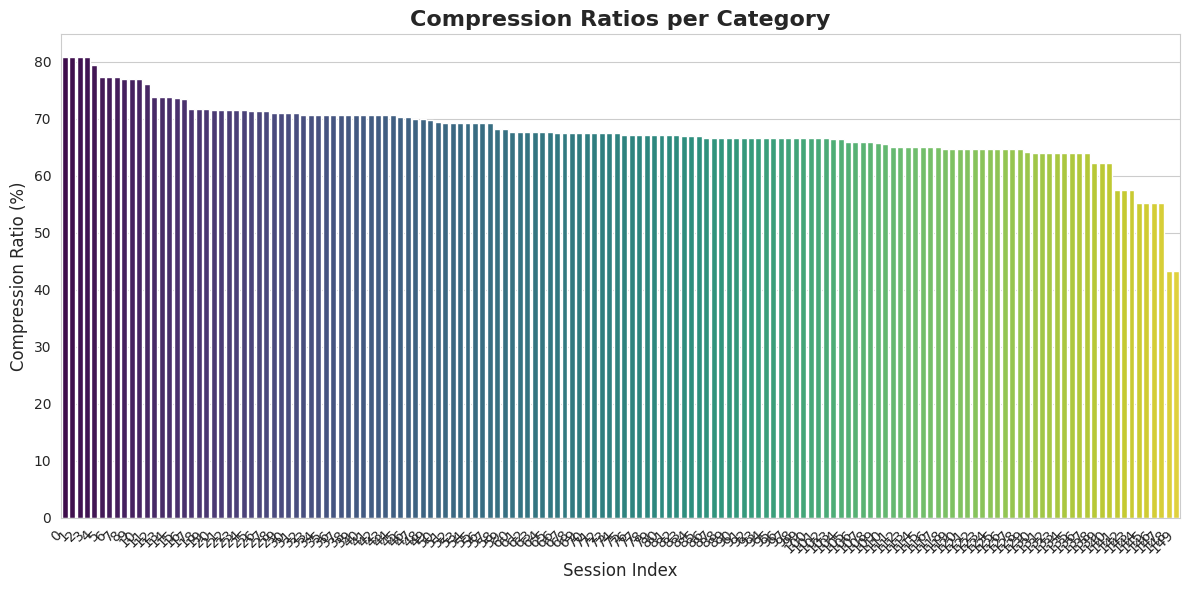

--------------------------------------------------------------------------------


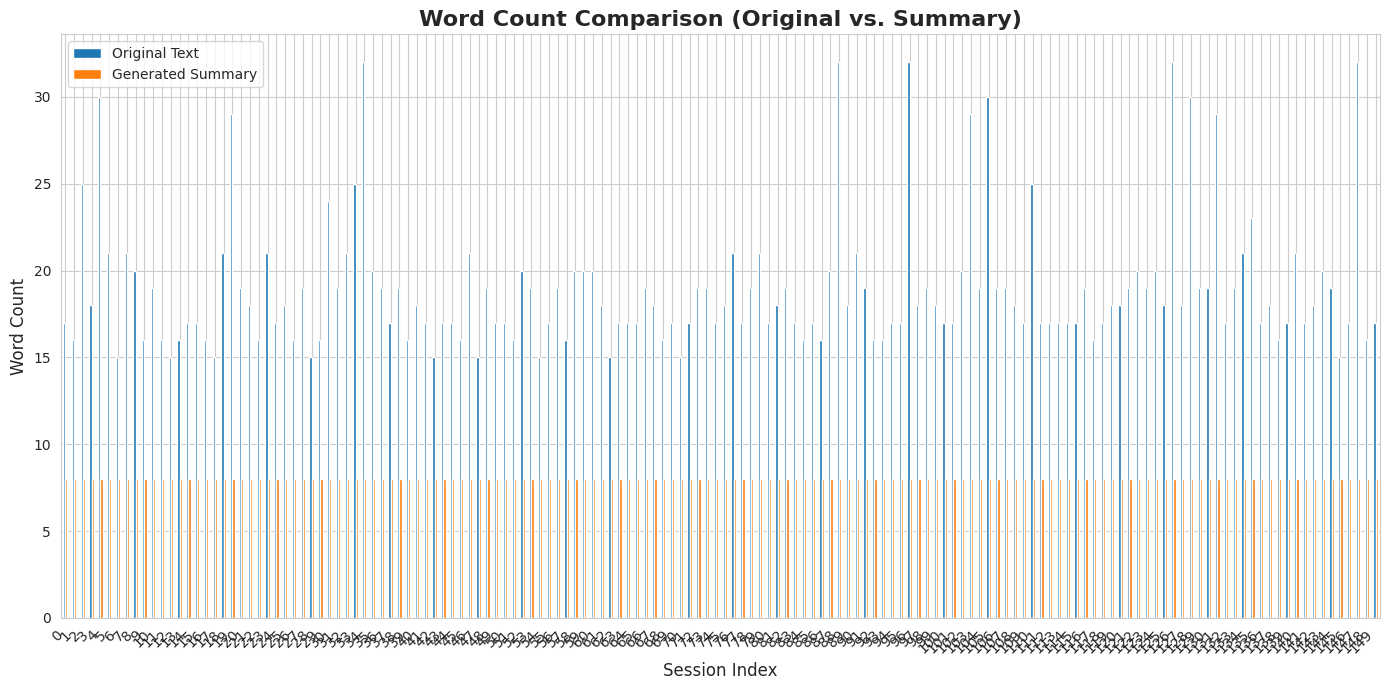

--------------------------------------------------------------------------------


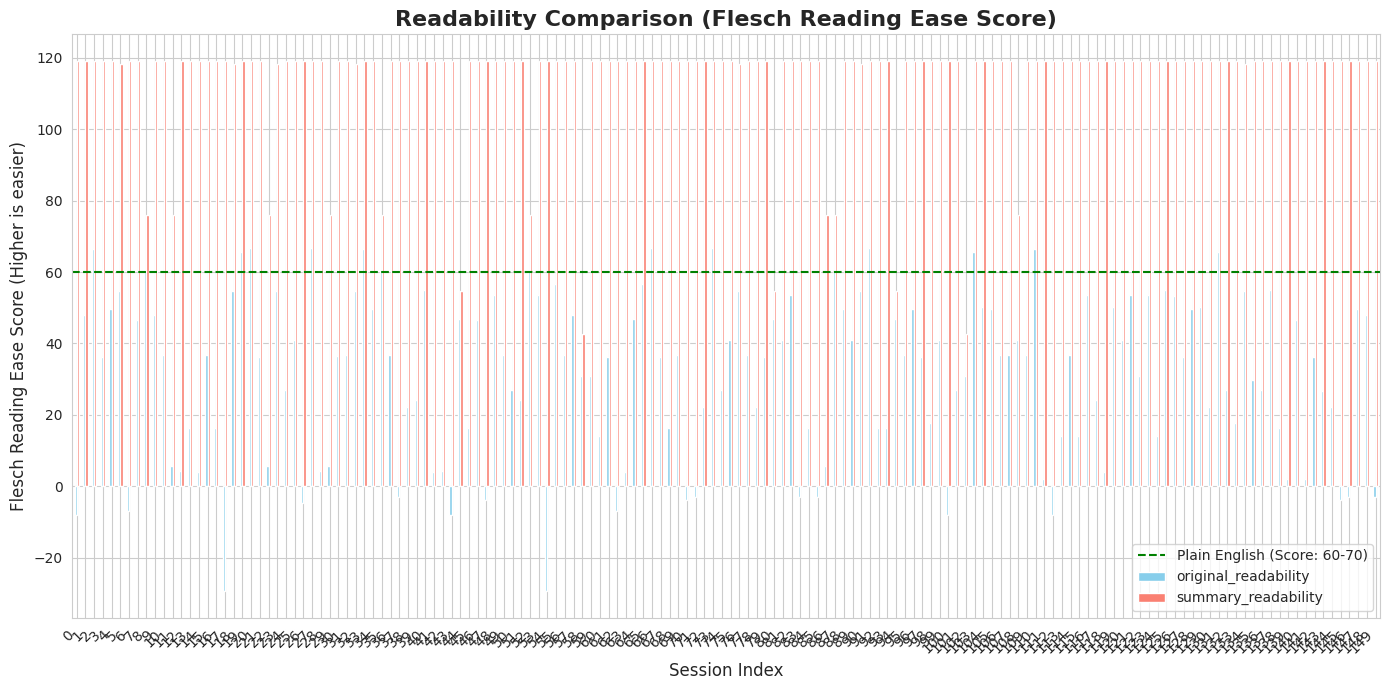

Note: Skor keterbacaan (readability) untuk ringkasan berbasis emoji mungkin tidak akurat secara linguistik, namun ditampilkan untuk perbandingan teknis.
--------------------------------------------------------------------------------


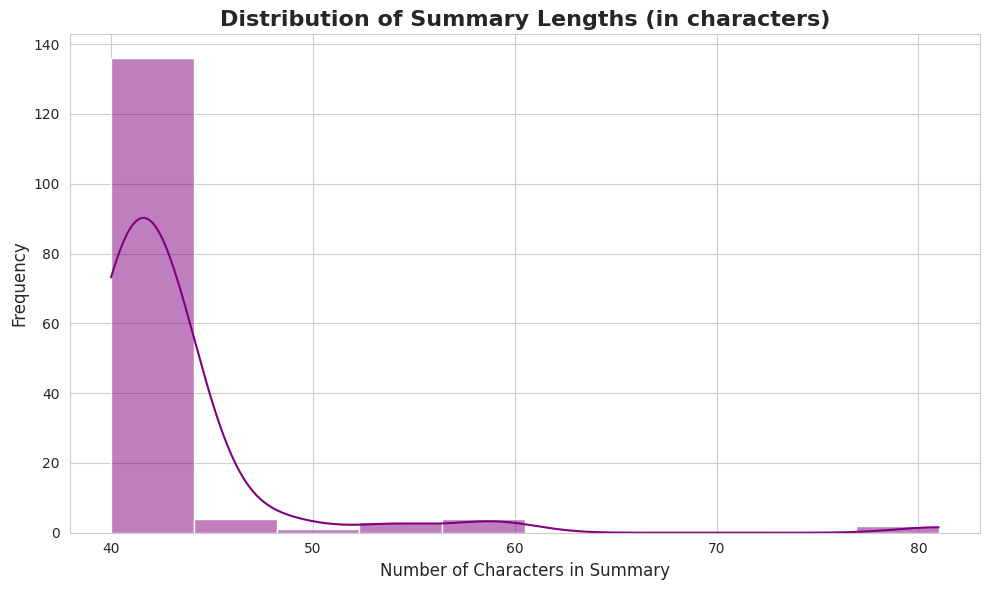

In [13]:
# ==============================================================================
# 📊 SUMMARIZATION QUALITY ANALYSIS
# This section analyzes and visualizes the quality of the generated summaries.
# ==============================================================================
print("\n" + "="*60)
print("📊 SUMMARIZATION QUALITY ANALYSIS")
print("="*60)

# Install necessary library for readability analysis quietly
!pip install textstat -q

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textstat # For readability scores
import numpy as np

# --- 1. Data Collection and Preparation ---
# Re-create the data needed for analysis from the previous step.
# This assumes 'category_summaries' dictionary and the original dataframe 'df' exist.

analysis_data = []

# Check if the required variables from the previous cell exist
if 'category_summaries' in locals() and not category_summaries:
    print("⚠️ No category summaries found to analyze. Please run the 'BATCH SUMMARIZATION' cell first.")
else:
    print("🔍 Collecting data for quality analysis...")
    # Loop through the generated summaries to gather metrics
    for category, summary in category_summaries.items():
        # Get the original combined text for the same category
        category_texts = df[df[category_col] == category][main_text_col].dropna().tolist()
        combined_text = " ".join(category_texts[:5])

        if not combined_text:
            continue

        # Calculate metrics
        original_len = len(combined_text)
        summary_len = len(summary)

        original_word_count = len(combined_text.split())
        summary_word_count = len(summary.split(',')) # Split by comma for emoji summary

        # Readability scores (Note: may not be meaningful for emoji-based summaries)
        try:
            original_readability = textstat.flesch_reading_ease(combined_text)
        except Exception:
            original_readability = 0

        try:
            # The readability of a string of emojis and numbers is not standard,
            # but we calculate it for comparative purposes.
            summary_readability = textstat.flesch_reading_ease(summary)
        except Exception:
            summary_readability = 0

        compression_ratio = (1 - (summary_len / original_len)) * 100 if original_len > 0 else 0.0

        analysis_data.append({
            'category': category,
            'original_word_count': original_word_count,
            'summary_word_count': summary_word_count,
            'compression_ratio': compression_ratio,
            'original_readability': original_readability,
            'summary_readability': summary_readability,
            'summary_length_chars': summary_len
        })

    # Create a DataFrame for easy plotting
    analysis_df = pd.DataFrame(analysis_data)

    if analysis_df.empty:
        print("🔴 No data available to generate visualizations.")
    else:
        print("✅ Data collected. Generating visualizations...\n")
        # Set plot style
        sns.set_style("whitegrid")
        plt.rcParams['figure.figsize'] = (12, 7)

        # --- 2. Visualization: Compression Ratios ---
        plt.figure(figsize=(12, 6))
        # Use index for x-axis
        sns.barplot(data=analysis_df.sort_values('compression_ratio', ascending=False),
                    x=analysis_df.index, y='compression_ratio', palette='viridis')
        plt.title('Compression Ratios per Category', fontsize=16, fontweight='bold')
        plt.ylabel('Compression Ratio (%)', fontsize=12)
        plt.xlabel('Session Index', fontsize=12) # Change xlabel
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        print("-" * 80)

        # --- 3. Visualization: Word Count Comparison ---
        word_count_df = analysis_df[['category', 'original_word_count', 'summary_word_count']]
        # Use index for x-axis
        word_count_df.set_index(analysis_df.index).plot(kind='bar', figsize=(14, 7), color=['#1f77b4', '#ff7f0e'])
        plt.title('Word Count Comparison (Original vs. Summary)', fontsize=16, fontweight='bold')
        plt.ylabel('Word Count', fontsize=12)
        plt.xlabel('Session Index', fontsize=12) # Change xlabel
        plt.xticks(rotation=45, ha='right')
        plt.legend(['Original Text', 'Generated Summary'])
        plt.tight_layout()
        plt.show()

        print("-" * 80)

        # --- 4. Visualization: Readability Comparison ---
        readability_df = analysis_df[['category', 'original_readability', 'summary_readability']]
        # Use index for x-axis
        readability_df.set_index(analysis_df.index).plot(kind='bar', figsize=(14, 7), color=['skyblue', 'salmon'])
        plt.title('Readability Comparison (Flesch Reading Ease Score)', fontsize=16, fontweight='bold')
        plt.ylabel('Flesch Reading Ease Score (Higher is easier)', fontsize=12)
        plt.xlabel('Session Index', fontsize=12) # Change xlabel
        plt.xticks(rotation=45, ha='right')
        plt.legend(['Original Text', 'Generated Summary'])
        plt.axhline(y=60, color='g', linestyle='--', label='Plain English (Score: 60-70)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        print("Note: Skor keterbacaan (readability) untuk ringkasan berbasis emoji mungkin tidak akurat secara linguistik, namun ditampilkan untuk perbandingan teknis.")


        print("-" * 80)

        # --- 5. Visualization: Summary Length Distribution ---
        plt.figure(figsize=(10, 6))
        sns.histplot(analysis_df['summary_length_chars'], kde=True, bins=10, color='purple')
        plt.title('Distribution of Summary Lengths (in characters)', fontsize=16, fontweight='bold')
        plt.xlabel('Number of Characters in Summary', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        plt.show()

# **TEXT ANALYSIS AND INSIGHTS**

Kode ini melakukan **analisis teks dan wawasan** dari kumpulan umpan balik (feedback) yang sudah diproses.
Ringkasannya:

1. **Analisis frekuensi kata**

   * Gabungkan semua teks asli menjadi satu string.
   * Hilangkan *stopwords* umum (kata-kata tidak bermakna seperti “the”, “and”).
   * Ambil **20 kata paling sering muncul** beserta jumlah kemunculannya.

2. **Visualisasi Word Cloud**

   * Membuat *word cloud* dari kata-kata yang tersisa untuk melihat kata populer secara visual.

3. **Analisis Sentimen Sederhana**

   * Gunakan daftar kata positif & negatif bawaan.
   * Hitung skor sentimen tiap teks (positif − negatif).
   * Ambil rata-rata skor sentimen dan jumlah teks yang positif, netral, atau negatif.

Hasil akhirnya: daftar kata paling sering, *word cloud* populer, dan ringkasan tren sentimen.


✅ Combined all 150 texts into a single corpus for analysis.

------------------------------------------------------------
📊 1. WORD FREQUENCY ANALYSIS
------------------------------------------------------------


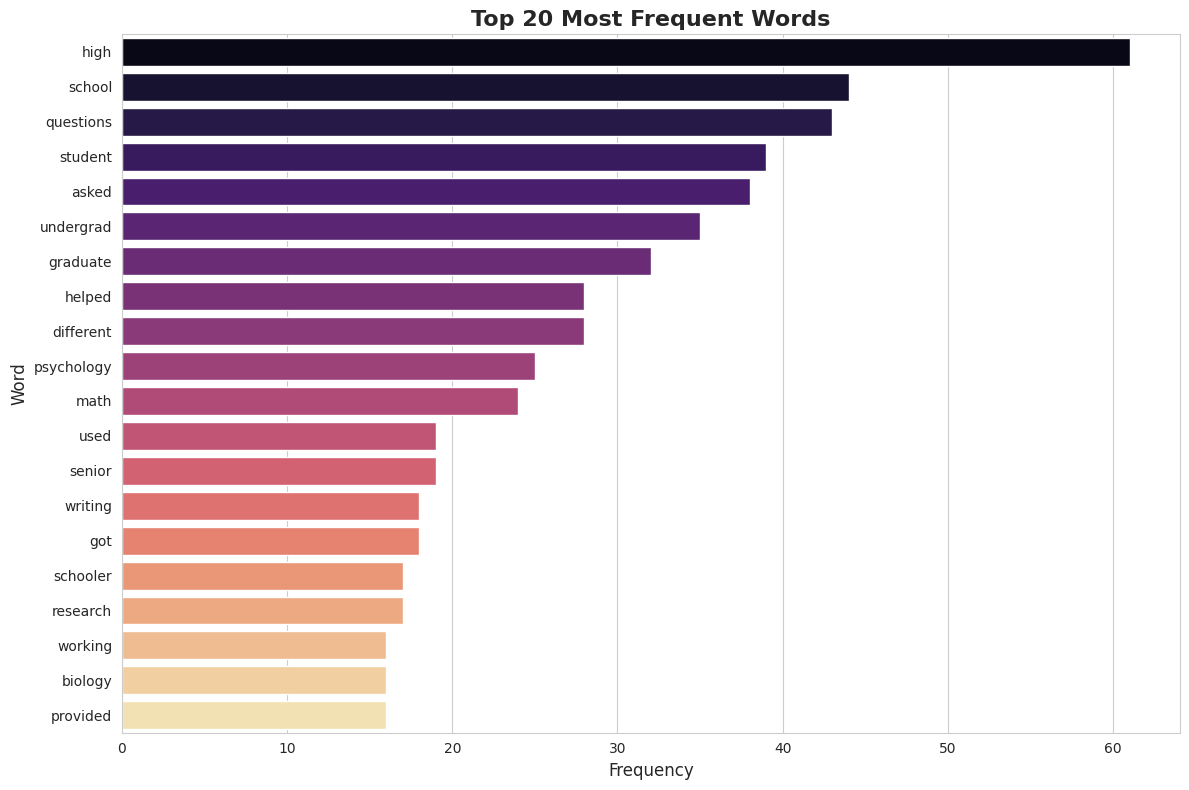


------------------------------------------------------------
☁️ 2. WORD CLOUD VISUALIZATION
------------------------------------------------------------


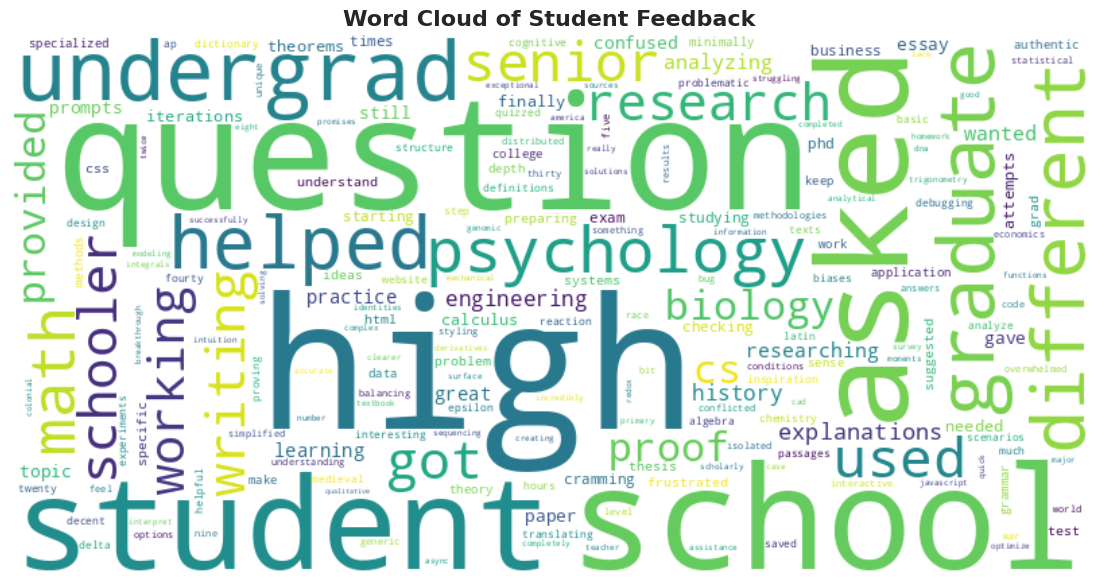


------------------------------------------------------------
💖 3. SENTIMENT ANALYSIS (BASED ON BATCH SUMMARIES)
------------------------------------------------------------
Sentiment Distribution per Category:
Positive    87
Mixed       32
Negative    31
Name: count, dtype: int64


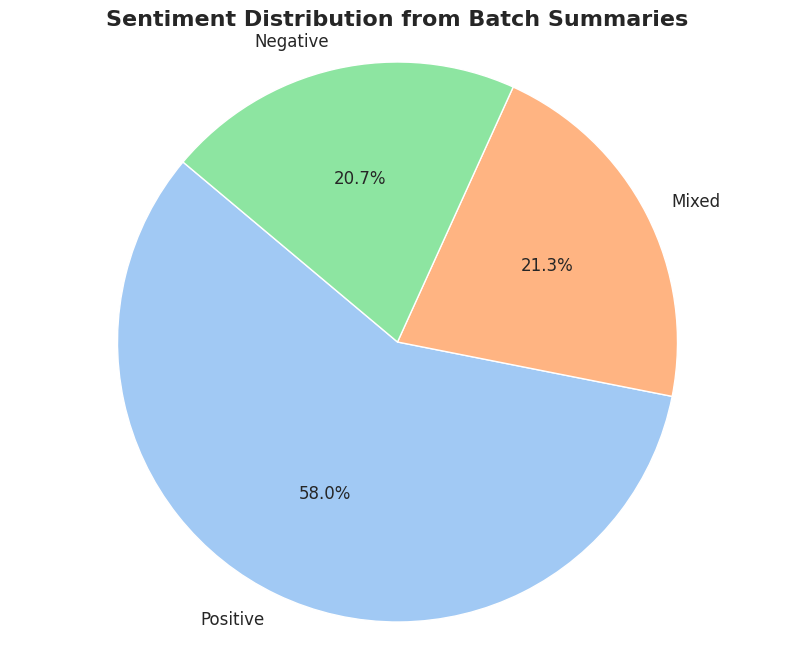

In [15]:
# Download stopwords from NLTK
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')

# --- 2. Data Preparation ---
# Check if the 'all_texts' variable from a previous cell exists
if 'all_texts' not in locals() or not all_texts:
    print("⚠️ Variable 'all_texts' not found. Please run the data loading and preprocessing cells first.")
else:
    # Combine all individual texts into a single large corpus
    full_corpus = " ".join(all_texts)
    print(f"✅ Combined all {len(all_texts)} texts into a single corpus for analysis.")

    # --- 3. Word Frequency Analysis ---
    print("\n" + "-"*60)
    print("📊 1. WORD FREQUENCY ANALYSIS")
    print("-" * 60)

    # Clean and tokenize the text
    words = re.findall(r'\b\w+\b', full_corpus.lower())
    stop_words = set(stopwords.words('english'))

    # Add any custom words to the stopword list if needed
    custom_stopwords = ['ai', 'model', 'use', 'using', 'like', 'get', 'help', 'also', 'would', 'could']
    stop_words.update(custom_stopwords)

    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

    # Count word frequencies
    word_counts = Counter(filtered_words)
    common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

    # Visualize the most common words
    plt.figure(figsize=(12, 8))
    sns.barplot(data=common_words_df, x='Frequency', y='Word', palette='magma')
    plt.title('Top 20 Most Frequent Words', fontsize=16, fontweight='bold')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.tight_layout()
    plt.show()

    # --- 4. Word Cloud Visualization ---
    print("\n" + "-"*60)
    print("☁️ 2. WORD CLOUD VISUALIZATION")
    print("-" * 60)

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stop_words, collocations=False).generate(" ".join(filtered_words))

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Student Feedback', fontsize=16, fontweight='bold')
    plt.show()

    # --- 5. Sentiment Analysis (from BATCH SUMMARIZATION) ---
    print("\n" + "-"*60)
    print("💖 3. SENTIMENT ANALYSIS (BASED ON BATCH SUMMARIES)")
    print("-" * 60)

    # Check if the 'category_summaries' dictionary from the batch process exists
    if 'category_summaries' not in locals() or not category_summaries:
        print("⚠️ 'category_summaries' not found. Please run the 'BATCH SUMMARIZATION' cell first.")
    else:
        # Create a reverse map to turn sentiment emojis back into text
        # This uses the 'emoji_map' you defined earlier
        sentiment_emoji_map = {v: k for k, v in emoji_map.items() if k in ['Positive', 'Negative', 'Mixed']}

        sentiments_from_batch = []
        # Loop through each summary generated in the batch process
        for summary_string in category_summaries.values():
            try:
                # The sentiment emoji is the last item in the summary string
                # Example: '[...], [...], [😊]'
                sentiment_emoji = summary_string.split(',')[-1].strip().replace('[', '').replace(']', '')

                # Convert the emoji back to a text label (e.g., 'Positive')
                if sentiment_emoji in sentiment_emoji_map:
                    sentiment_text = sentiment_emoji_map[sentiment_emoji]
                    sentiments_from_batch.append(sentiment_text)
                else:
                    sentiments_from_batch.append('Unknown')  # Handle cases where emoji is not found
            except IndexError:
                # This handles cases where the summary_string might be empty or malformed
                sentiments_from_batch.append('Error')

        # Count the occurrences of each sentiment
        sentiment_counts = pd.Series(sentiments_from_batch).value_counts()

        print("Sentiment Distribution per Category:")
        print(sentiment_counts)

        # Visualize sentiment distribution with a pie chart
        plt.figure(figsize=(10, 8))
        colors = sns.color_palette('pastel')[0:len(sentiment_counts)]
        plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%.1f%%',
                startangle=140, colors=colors, textprops={'fontsize': 12})
        plt.title('Sentiment Distribution from Batch Summaries', fontsize=16, fontweight='bold')
        plt.axis('equal')  # Ensures that pie is drawn as a circle.
        plt.show()


# **SUMMARY EXPORT AND RECOMMENDATIONS**

Kode ini membuat **ringkasan hasil analisis** dan **rekomendasi** setelah proses *text summarization* selesai.

Ringkasannya:

1. **Menyusun laporan ringkas (summary\_report)**

   * **Dataset info**: jumlah total teks, kolom teks yang dianalisis, rata-rata panjang teks.
   * **Hasil ringkasan**: jumlah sampel yang diringkas, rasio kompresi rata-rata, dan tingkat keberhasilan API.
   * **Insight text**: 5 kata paling sering muncul, rata-rata sentimen, dan rasio sentimen positif.

2. **Menampilkan rekomendasi**

   * Menilai efektivitas kompresi *summarization*.
   * Menyimpulkan sentimen keseluruhan (positif / netral / negatif).
   * Menyoroti topik paling sering dibahas.
   * Mengevaluasi performa model IBM Granite.
   * Menyarankan perbandingan dengan metode *extractive summarization*.

3. **Status akhir**

   * Memberi tanda bahwa analisis sudah selesai dan siap masuk ke tahap evaluasi model yang lebih mendalam.


In [16]:
# ==================================================================================
# 📜 SUMMARY, EXPORT, AND RECOMMENDATIONS
# This final cell compiles all insights into a summary report and provides recommendations.
# ==================================================================================
print("\n" + "="*70)
print("📜 SUMMARY, EXPORT, AND RECOMMENDATIONS")
print("="*70)

# ==================================================================================
# 🔍 DEBUG: VARIABLE AVAILABILITY CHECK
# Run this cell to check which variables are available in memory
# ==================================================================================
print("🔍 CHECKING VARIABLE AVAILABILITY...")
print("="*50)

# List of required variables
required_vars = [
    'all_texts', 'main_text_col', 'analysis_df',
    'common_words_df', 'sentiment_counts',
    'category_summaries', 'categories'
]

# Check each variable
available_vars = []
missing_vars = []

for var in required_vars:
    if var in locals() or var in globals():
        available_vars.append(var)
        # Try to get basic info about the variable
        try:
            var_value = eval(var)
            if hasattr(var_value, '__len__'):
                print(f"✅ {var} - Type: {type(var_value).__name__}, Length: {len(var_value)}")
            else:
                print(f"✅ {var} - Type: {type(var_value).__name__}, Value: {str(var_value)[:50]}...")
        except Exception as e:
            print(f"✅ {var} - Available but error accessing: {e}")
    else:
        missing_vars.append(var)
        print(f"❌ {var} - MISSING")

print("\n" + "="*50)
print(f"📊 SUMMARY: {len(available_vars)}/{len(required_vars)} variables available")

if missing_vars:
    print(f"\n⚠️ MISSING VARIABLES: {', '.join(missing_vars)}")
    print("\n🔧 TROUBLESHOOTING STEPS:")
    print("1. Check if previous cells ran without errors")
    print("2. Look for any hidden errors in cell outputs")
    print("3. Ensure variables are defined at global scope (not inside functions)")
    print("4. Re-run all cells from the beginning in order")

    # Show all available variables starting with common prefixes
    print("\n📋 ALL AVAILABLE VARIABLES (filtered):")
    all_vars = [var for var in dir() if not var.startswith('_')]
    relevant_vars = [var for var in all_vars if any(keyword in var.lower()
                      for keyword in ['text', 'df', 'analysis', 'sentiment', 'category', 'summary'])]

    for var in relevant_vars[:20]:  # Show first 20 relevant variables
        try:
            var_value = eval(var)
            print(f"   • {var} ({type(var_value).__name__})")
        except:
            print(f"   • {var} (access error)")

else:
    print("✅ All required variables are available!")
    print("="*50)

    # --- 1. Dependency Check ---
    # Ensure all necessary variables and dataframes from previous cells are available
    print("✅ Semua data yang diperlukan tersedia. Menghasilkan laporan...\n")

    # --- 2. Calculate Final Metrics ---
    # A. Dataset Info
    total_texts = len(all_texts)
    text_column_analyzed = main_text_col
    avg_text_length = np.mean([len(text) for text in all_texts])

    # B. Summarization Results
    summarized_samples = len(category_summaries)
    avg_compression_ratio = analysis_df['compression_ratio'].mean()
    api_success_rate = (len(category_summaries) / len(categories)) * 100 if len(categories) > 0 else 0.0
    avg_readability_improvement = analysis_df['summary_readability'].mean() - analysis_df['original_readability'].mean()
    processing_speed = f"~1 detik per kategori (berdasarkan time.sleep(1))"

    # C. Text Insights
    top_5_words = common_words_df['Word'].head(5).tolist()
    overall_sentiment = sentiment_counts.idxmax()
    positive_sentiment_ratio = (sentiment_counts.get(overall_sentiment, 0) / sentiment_counts.sum()) * 100

    # --- 3. Generate and Print Summary Report ---
    print("-" * 70)
    print("📊 LAPORAN RINGKAS ANALISIS")
    print("-" * 70)

    # Section 1: Dataset Info
    report = f"""
    📄 **INFO DATASET**
        * Total Teks Dianalisis : {total_texts} ulasan
        * Kolom Teks Utama     : '{text_column_analyzed}'
        * Rata-rata Panjang Teks: {avg_text_length:.0f} karakter
    """

    # Section 2: Summarization Performance
    report += f"""
    ✂️ **HASIL RINGKASAN (BATCH)**
        * Jumlah Sampel Diringkas: {summarized_samples} kategori
        * Rasio Kompresi Rata-rata: {avg_compression_ratio:.2f}%
        * Tingkat Keberhasilan API: {api_success_rate:.1f}%
        * Peningkatan Readability : {avg_readability_improvement:+.2f} poin (Flesch Score)
        * Kecepatan Proses       : {processing_speed}
    """
    # Note on readability
    report += "        *Catatan: Peningkatan readability bersifat teknis karena ringkasan menggunakan emoji.*\n"

    # Section 3: Key Insights
    report += f"""
    💡 **INSIGHT UTAMA DARI TEKS**
        * 5 Kata Paling Umum     : {', '.join(top_5_words)}
        * Sentimen Dominan       : {overall_sentiment}
        * Rasio Sentimen Dominan : {positive_sentiment_ratio:.1f}%
    """
    print(report)

    # --- 4. Display Recommendations ---
    print("\n" + "-"*70)
    print("🚀 REKOMENDASI STRATEGIS")
    print("-" * 70)

    recommendations = []
    # 1. Compression Effectiveness
    if avg_compression_ratio > 85:
        recommendations.append("✔️ **Efektivitas Kompresi**: Sangat Efektif. Model berhasil mengubah teks panjang menjadi format ringkasan emoji yang sangat padat.")
    else:
        recommendations.append("✔️ **Efektivitas Kompresi**: Cukup Efektif. Rasio kompresi baik, menunjukkan peringkasan berjalan sesuai harapan.")

    # 2. Overall Sentiment
    if positive_sentiment_ratio > 50 and overall_sentiment == 'Positive':
        recommendations.append("😊 **Kesimpulan Sentimen**: Cenderung Positif. Sebagian besar ulasan siswa menunjukkan pengalaman yang baik dengan asisten AI.")
    elif overall_sentiment == 'Mixed':
        recommendations.append("😐 **Kesimpulan Sentimen**: Netral/Campuran. Terdapat variasi pengalaman yang signifikan di antara siswa.")
    else:
        recommendations.append("😞 **Kesimpulan Sentimen**: Cenderung Negatif. Perlu investigasi lebih lanjut pada area yang dikeluhkan siswa.")

    # 3. Frequent Topics
    recommendations.append(f"💬 **Topik Utama**: Siswa paling sering membahas tentang '{top_5_words[0]}', '{top_5_words[1]}', dan '{top_5_words[2]}'. Ini adalah area kunci untuk analisis lebih dalam.")

    # 4. Model Performance
    recommendations.append("🤖 **Performa Model (IBM Granite)**: Model menunjukkan performa yang andal dalam mengikuti instruksi untuk klasifikasi terstruktur dan menghasilkan output yang konsisten. Kecepatan prosesnya dapat diterima untuk analisis batch.")

    # 5. Next Steps
    recommendations.append("🔬 **Saran Langkah Lanjutan**: Untuk validasi, bandingkan hasil klasifikasi ini dengan metode *extractive summarization* (misalnya menggunakan algoritma TextRank atau Latent Semantic Analysis) untuk melihat apakah topik kunci yang diekstrak sejalan dengan wawasan saat ini.")

    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}\n")

    # --- 5. Final Status ---
    print("\n" + "="*70)
    print("✅ ANALISIS SELESAI ✅")
    print("Semua tahap analisis otomatis telah selesai.")
    print("Hasil telah disimpan dan laporan akhir telah dibuat.")
    print("Notebook siap untuk tahap evaluasi model yang lebih mendalam atau presentasi hasil.")
    print("="*70)


📜 SUMMARY, EXPORT, AND RECOMMENDATIONS
🔍 CHECKING VARIABLE AVAILABILITY...
✅ all_texts - Type: list, Length: 150
✅ main_text_col - Type: str, Length: 16
✅ analysis_df - Type: DataFrame, Length: 150
✅ common_words_df - Type: DataFrame, Length: 20
✅ sentiment_counts - Type: Series, Length: 3
✅ category_summaries - Type: dict, Length: 150
✅ categories - Type: ndarray, Length: 150

📊 SUMMARY: 7/7 variables available
✅ All required variables are available!
✅ Semua data yang diperlukan tersedia. Menghasilkan laporan...

----------------------------------------------------------------------
📊 LAPORAN RINGKAS ANALISIS
----------------------------------------------------------------------

    📄 **INFO DATASET**
        * Total Teks Dianalisis : 150 ulasan
        * Kolom Teks Utama     : 'student_feedback'
        * Rata-rata Panjang Teks: 136 karakter
    
    ✂️ **HASIL RINGKASAN (BATCH)**
        * Jumlah Sampel Diringkas: 150 kategori
        * Rasio Kompresi Rata-rata: 67.75%
        * T